In [9]:
##### This Jupyter notebook first calculates pairwise distances using the coordinates of selected residues, 
##### and then removes and selects features using variances, Chi-Squared Test scores, and AMINO (Ravindra et al. doi.org/10.1039/C9ME00115H). 
##### Please ensure that you have the AMINO codes (amino.py, amino_fast_mod.py, amino_main_mod.py) in the same directories. 
##### Please ensure you have properly set up the conda environment with all libraries.

##### Author: MO (latest update: Aug 18, 2023)
##### Updated: MR (latest update: May 28, 2024) 

In [10]:
##### User inputs #####
##### Only change if using your own system. If using our inputs, no need to change.

nDataPoints = 754  # Number of data points for each class (*note: each class should have the same number of data points)
dataset = '/home/jiwonjjeong/gk-lab/Automated-CV-Design/tests/2_feature_extraction/sample_CA_coords.csv'  # Dataset to analyze
nclasses = 3  # Number of classes in the dataset
# i.e., for MFSD2A, it is 3 classes: OFS, OcS, IFS
nFeat = 1570 # This will be calculated in script step 3.1. and then need to re-run 

In [11]:
### STEP 0. Import libraries
import amino_fast_mod as amino
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import multiprocessing
import kneed

In [12]:
### STEP 1. Load input data
dfReduced = pd.read_csv('../2_feature_extraction/sample_CA_post_variance.csv')

In [13]:
dfReduced

,res39.137,res39.166,res39.167,res39.199,res39.201,res39.202,res39.233,res39.292,res39.293,res39.294,...,res472.491,res476.491,res477.491,res480.491,res481.491,res483.491,res484.491,res487.491,res488.491,class
0,48.516654,15.550879,11.782464,30.720754,36.832815,39.005820,47.006240,39.321359,36.689536,33.942176,...,30.878408,25.264388,23.555946,19.585102,17.624119,15.016122,13.801543,8.455018,8.115905,0
1,48.391578,15.821387,12.044111,32.146361,38.290039,39.929612,48.520857,35.755806,34.992586,33.156242,...,31.000032,26.593679,24.836052,20.399656,18.600287,15.646685,14.316205,9.584594,7.850335,0
2,48.898433,15.792147,12.199005,30.827692,36.019894,37.502753,46.577420,37.043157,33.935063,32.014517,...,29.571971,26.101338,24.007810,20.054880,17.730764,15.170421,13.881688,9.780254,7.825675,0
3,48.987007,15.815029,12.134304,31.922840,37.438372,38.124749,47.552086,34.514976,34.012088,32.750779,...,29.877113,25.897959,24.251504,20.081663,18.004194,15.031151,14.023508,9.551396,7.828224,0
4,50.778727,16.264586,12.559692,31.695209,37.816740,38.221784,47.203244,38.106838,37.139492,34.704269,...,29.727102,26.274326,24.131379,19.703288,17.837260,15.216900,13.649606,9.804452,7.693616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,46.749142,13.288223,9.803680,32.612726,37.012895,38.300388,47.556014,43.548585,43.659433,40.167670,...,27.269869,22.993735,21.422974,16.686213,14.928687,12.062921,10.524907,6.062552,5.134690,2
2258,46.792536,13.969725,10.455201,32.990426,37.222045,38.535049,47.616553,41.644814,42.562491,39.068258,...,26.681468,22.503795,20.751810,16.736734,14.995892,12.388268,10.567933,6.428710,5.301362,2
2259,47.176977,13.284322,9.739256,32.111101,36.319202,37.142845,47.058533,43.688228,43.763872,40.519359,...,27.728934,23.740447,22.090317,17.511157,15.829649,12.607925,11.031930,6.645588,5.484716,2
2260,46.678082,14.040287,10.573478,32.101427,35.989655,37.122386,47.024755,44.893687,44.846179,41.329235,...,27.437300,23.264725,21.579145,16.790344,15.274260,12.411037,10.922860,6.239806,5.221792,2


In [14]:
## Apply processing step 

In [15]:
dfReduced = dfReduced.iloc[:, :-1]

In [16]:
### STEP 2. Categorize our continuous variables into discrete bins. 
### Author: MR (latest update: May 28, 2024) 
### Employed the quantile-based discretization function from the widely used pandas library (qcut function) 

In [17]:
# Apply binning to each column and store the results in a dictionary
binned_columns = {col: pd.qcut(dfReduced[col], q=5, labels=False) for col in dfReduced}

# Create a new DataFrame from the dictionary
binned_df = pd.DataFrame(binned_columns)

# To defragment the DataFrame if you have done many operations on it, you can make a copy
binned_df = binned_df.copy()

In [18]:
### STEP 2. 
### Author: MR (latest update: May 28, 2024) 
gc.collect()
zeroList = [0]*nDataPoints # class 1
oneList = [1]*nDataPoints # class 2
twoList = [2]*nDataPoints # class 3
binned_df['class'] = np.array(zeroList + oneList + twoList)

In [19]:
### STEP 3. Calculate Chi-Squared Scores
### Author: MR (latest update: May 28, 2024) 

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

X = binned_df.drop(columns=['class'])  # Extract features (adjust 'target' column name)
y = binned_df['class']  # Extract target variable

test = SelectKBest(score_func=chi2, k='all') # Edit this line from 'all' to nFeat value (1570) see below
#test = SelectKBest(score_func=chi2, k=1570) 

# Fit and transform the data to select the top nFeat
X_selected = test.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = test.get_support(indices=True)

# Create a new DataFrame with the selected features
selected_dfReduced = binned_df.iloc[:, selected_feature_indices]
#selected_dfReduced

In [21]:
### STEP 4: Plot for Chi-Squared Score vs Number of Features (pairwise distances)
### Author: MR (latest update: May 28, 2024) 

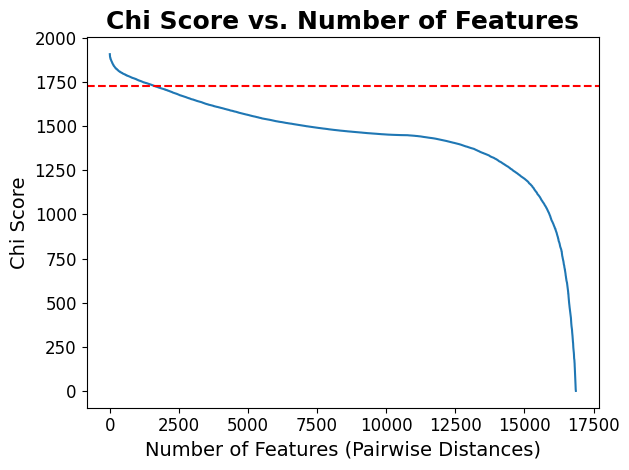

In [22]:
X_kbest_features = test.fit_transform(X, y)

# Get the scores for each feature
chi_scores = test.scores_

# Sort the scores in descending order
sorted_indices = np.argsort(chi_scores)[::-1]
sorted_scores = chi_scores[sorted_indices]

plt.plot(sorted_scores)
plt.xlabel('Number of Features (Pairwise Distances)', fontsize=14)
plt.ylabel('Chi Score', fontsize=14)
plt.title('Chi Score vs. Number of Features', fontweight='bold', fontsize=18)
# Edit according to new threshold 
plt.axhline(y=1730.3673740052893, color='r', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig('./chi_knee_feature_num.pdf', dpi=300)
plt.show()

In [23]:
### STEP 4.1 Calculate nFeat
### Author: MR (latest update: May 28, 2024) 
### Using the Kneedle Algorithm (reference: 'Finding a "Kneedle" in a Haystack: Detecting Knee Points in System Behavior') 
### Will calculate the elbow point, where the scores plateau begins and this will be our nFeat

In [24]:
from kneed import KneeLocator

x = range(1, len(sorted_scores) + 1)

# Find the knee point
knee_locator = KneeLocator(x, sorted_scores, curve='convex', direction='decreasing', S=100)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

The knee point is at x (nFeat) = 1570, and score of: 1730.3673740052893


In [25]:
# At this point make sure to edit nFeat variable in step 3 and re-run. 

In [26]:
dfFinal_bin= selected_dfReduced

In [27]:
columns_to_keep = dfFinal_bin.columns.tolist()

# Filter dfReduced to only include columns with names that are in dfFinal_bin
dfFinal = dfReduced[columns_to_keep]

In [28]:
dfFinal

,res39.137,res39.166,res39.167,res39.199,res39.201,res39.202,res39.233,res39.292,res39.293,res39.294,...,res469.491,res472.491,res476.491,res477.491,res480.491,res481.491,res483.491,res484.491,res487.491,res488.491
0,48.516654,15.550879,11.782464,30.720754,36.832815,39.005820,47.006240,39.321359,36.689536,33.942176,...,35.149551,30.878408,25.264388,23.555946,19.585102,17.624119,15.016122,13.801543,8.455018,8.115905
1,48.391578,15.821387,12.044111,32.146361,38.290039,39.929612,48.520857,35.755806,34.992586,33.156242,...,34.991020,31.000032,26.593679,24.836052,20.399656,18.600287,15.646685,14.316205,9.584594,7.850335
2,48.898433,15.792147,12.199005,30.827692,36.019894,37.502753,46.577420,37.043157,33.935063,32.014517,...,33.846364,29.571971,26.101338,24.007810,20.054880,17.730764,15.170421,13.881688,9.780254,7.825675
3,48.987007,15.815029,12.134304,31.922840,37.438372,38.124749,47.552086,34.514976,34.012088,32.750779,...,34.033295,29.877113,25.897959,24.251504,20.081663,18.004194,15.031151,14.023508,9.551396,7.828224
4,50.778727,16.264586,12.559692,31.695209,37.816740,38.221784,47.203244,38.106838,37.139492,34.704269,...,33.911787,29.727102,26.274326,24.131379,19.703288,17.837260,15.216900,13.649606,9.804452,7.693616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,46.749142,13.288223,9.803680,32.612726,37.012895,38.300388,47.556014,43.548585,43.659433,40.167670,...,31.892309,27.269869,22.993735,21.422974,16.686213,14.928687,12.062921,10.524907,6.062552,5.134690
2258,46.792536,13.969725,10.455201,32.990426,37.222045,38.535049,47.616553,41.644814,42.562491,39.068258,...,31.243706,26.681468,22.503795,20.751810,16.736734,14.995892,12.388268,10.567933,6.428710,5.301362
2259,47.176977,13.284322,9.739256,32.111101,36.319202,37.142845,47.058533,43.688228,43.763872,40.519359,...,32.346547,27.728934,23.740447,22.090317,17.511157,15.829649,12.607925,11.031930,6.645588,5.484716
2260,46.678082,14.040287,10.573478,32.101427,35.989655,37.122386,47.024755,44.893687,44.846179,41.329235,...,31.829102,27.437300,23.264725,21.579145,16.790344,15.274260,12.411037,10.922860,6.239806,5.221792


In [29]:
### STEP 5. Make OP data for AMINO
gc.collect()
names = []
trajs = {}

for i in list(dfFinal.columns.values):
    names.append(i)
    trajs[i] = []

for j in range(len(list(dfFinal.columns.values))):
    trajs[names[j]] = dfFinal[names[j]].tolist()

all_ops = []

for k in names:
    all_ops.append(amino.OrderParameter(k, trajs[k]))

print("We have %d OPs in total." % len(all_ops))
print("OPs: %s" % names)

We have 16863 OPs in total.
OPs: ['res39.137', 'res39.166', 'res39.167', 'res39.199', 'res39.201', 'res39.202', 'res39.233', 'res39.292', 'res39.293', 'res39.294', 'res39.295', 'res39.296', 'res39.297', 'res39.298', 'res39.299', 'res39.300', 'res39.301', 'res39.302', 'res39.303', 'res39.304', 'res39.305', 'res39.307', 'res39.308', 'res39.311', 'res39.312', 'res39.313', 'res39.314', 'res39.315', 'res39.316', 'res39.317', 'res39.318', 'res39.335', 'res39.336', 'res39.337', 'res39.338', 'res39.339', 'res39.340', 'res39.341', 'res39.342', 'res39.343', 'res39.344', 'res39.345', 'res39.346', 'res39.347', 'res39.348', 'res39.349', 'res39.350', 'res39.351', 'res39.352', 'res39.353', 'res39.358', 'res39.359', 'res39.360', 'res39.361', 'res39.362', 'res39.363', 'res39.364', 'res39.365', 'res39.366', 'res39.367', 'res39.368', 'res39.369', 'res39.370', 'res39.371', 'res39.372', 'res39.373', 'res39.374', 'res39.382', 'res39.383', 'res39.384', 'res39.385', 'res39.386', 'res39.387', 'res39.388', 'res

In [1]:
### STEP 6. Perform AMINO
gc.collect()
# The -n flag can be used to specify a maximum number of order parameters in the reduced COLVAR (default = 20).
# The default value for bins if the -b flag is omitted is 50.
# Try different bins depening on system

final_ops = amino.find_ops(all_ops, 10, 30, distortion_filename='distortion_array')   # find_ops(old_ops, max_outputs=10, bins=30, bandwidth=None, kernel='epanechnikov', distortion_filename=None, return_memo=False, weights=None)

myfile2 = open('output2_final_OPs.txt', 'w')
print("\nAMINO order parameters:")
for i in final_ops:
    myfile2.write("%s\n" % i)
    print(i)
myfile2.close()

NameError: name 'gc' is not defined

In [ ]:
dfAminoCols = pd.read_csv("output2_final_OPs.txt", names=["aminoColNames"])
aminoColNames = dfAminoCols['aminoColNames'].tolist()
dfAmino = dfFinal[aminoColNames]
dfAmino['class'] = np.array(zeroList + oneList + twoList)
dfAmino.to_csv('chi_amino_df.csv', encoding='utf-8', index=False)

/tmp/ipykernel_1292/3886149412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfAmino['class'] = np.array(zeroList + oneList + twoList)


: 

: 

: 

: 